# (Pseudo-) Online Feature Calculation

This notebook is used to receive data from the HoloLens 2. The data is chunked in 10 second pieces.

In [53]:
from flask import Flask, request
import json
import requests
import os
import pandas as pd

## Read the data from the newly arrived csv-file and call the feature calculation

### Run FeaturesCalculation notebook to make its function accessible here

In [54]:
%run -i FeatureCalculation.ipynb

## Calculate the features and save them as csv
See `FeaturesCalculation.ipynb`for more details.

In [55]:
def calculate_features_for_10s_chunk(newdf):
    list_of_features = []
    newdf_valid = only_valid_data(newdf)
    if (len(newdf_valid) > 1):
        df_fixations = get_fixation_df(newdf_valid)
        features = calculate_fixation_features(df_fixations, 10)
        blinks = calculate_blink_features(newdf,10)
        directions = calculate_directions_of_list(df_fixations) 
        density = calculate_fixation_density(newdf_valid, df_fixations)
        features.update(blinks)
        features.update(directions)
        features.update(density)
        features["label"] = ""
        features["duration"] = "10"
        features["participant_id"] = "002"            
        list_of_features.append(features)  
        flat_ls = [item for sublist in list_of_features for item in sublist]
        feature_file_path = save_as_csv(list_of_features, "001", './OnlineFeatureFiles/')
        return feature_file_path

In [56]:
def csv_to_features(gaze_data_file_path):
    # continue only if the csv-file contains data
    if os.stat(gaze_data_file_path).st_size != 0:
        df = pd.read_csv(gaze_data_file_path)
        feature_file_path = calculate_features_for_10s_chunk(df)
        print(f"Feature calculation done for: {gaze_data_file_path}")
        print(f"Feature file path: {feature_file_path}")
        return feature_file_path
    else:
        print(f"File {gaze_data_file_path} is empty!")
        return ""
# csv_to_features("./HL2_DataCollection/2022_09_23-13_41_19-Alex01-Inspection02.csv")
# uncomment the line above to test the function with a local csv file

## Run SVM notebook to make its function accessible here
If you are not training on normalized data this make take a while.

Columns of the CSV file are 19 features, label of the activity, duration or the timespan of the activity, and the ID of the participant:
Features:


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
0,250.882353,666,16554.228164,0.484848,0.606061,369.479986
1,246.742857,900,23549.020168,0.529412,0.529412,363.711018
2,237.257143,1067,36627.431933,0.441176,0.558824,266.246748
3,293.137931,767,35208.551724,0.500000,0.500000,319.553727
4,199.125000,566,12614.163462,0.589744,0.487179,305.832090
5,262.562500,867,36411.415323,0.516129,0.580645,236.757891
6,204.175000,733,16987.430128,0.538462,0.512821,445.453567
7,221.540541,733,19568.977477,0.583333,0.500000,538.273012
8,430.095238,2567,322794.690476,0.800000,0.450000,77.460002
9,227.805556,533,8651.246825,0.914286,0.457143,132.320562


Labels:


0    Inspection
1    Inspection
2    Inspection
3    Inspection
4    Inspection
5    Inspection
6    Inspection
7    Inspection
8       Reading
9       Reading
Name: label, dtype: object

Normalized Features:


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
0,0.412048,0.144783,0.013814,0.527009,0.743802,0.238355
1,0.405249,0.195652,0.019651,0.575448,0.649733,0.234633
2,0.389670,0.231957,0.030564,0.479540,0.685829,0.171758
3,0.481448,0.166739,0.029380,0.543478,0.613636,0.206147
4,0.327042,0.123043,0.010526,0.641026,0.597902,0.197295
5,0.431232,0.188478,0.030384,0.561010,0.712610,0.152735
6,0.335336,0.159348,0.014175,0.585284,0.629371,0.287366
7,0.363857,0.159348,0.016330,0.634058,0.613636,0.347245
8,0.706387,0.558043,0.269361,0.869565,0.552273,0.049970
9,0.374147,0.115870,0.007219,0.993789,0.561039,0.085361


Accuracy Linear Kernel: 0.8701298701298701
Accuracy Polynomial Kernel: 0.8831168831168831
Accuracy Radial Basis Kernel: 0.8701298701298701
Accuracy Sigmoid Kernel: 0.3246753246753247
CM Linear:
[[22  0  4]
 [ 1 25  0]
 [ 5  0 20]]
CM Polynomial:
[[23  0  3]
 [ 1 25  0]
 [ 5  0 20]]
CM Radial:
[[22  0  4]
 [ 1 25  0]
 [ 5  0 20]]
CM Sigmoid:
[[14  7  5]
 [ 0  9 17]
 [ 3 20  2]]


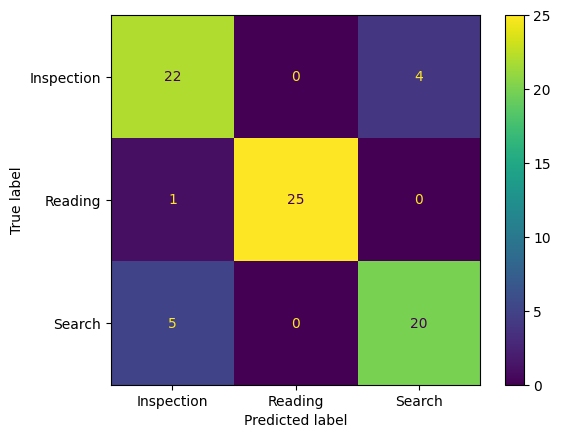

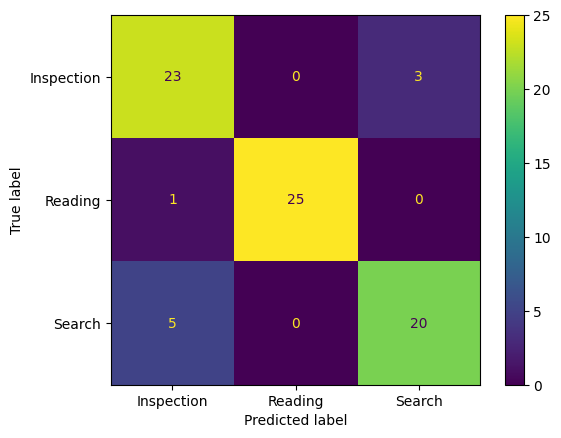

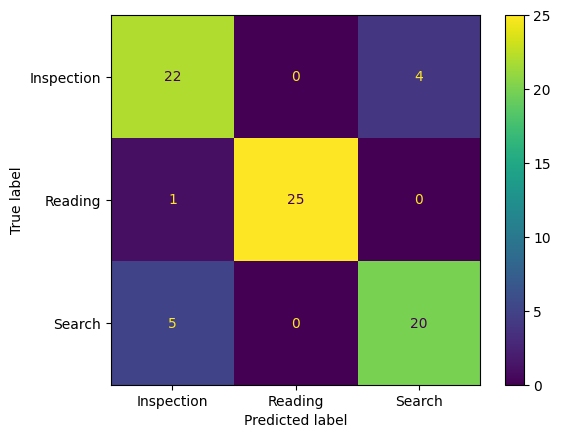

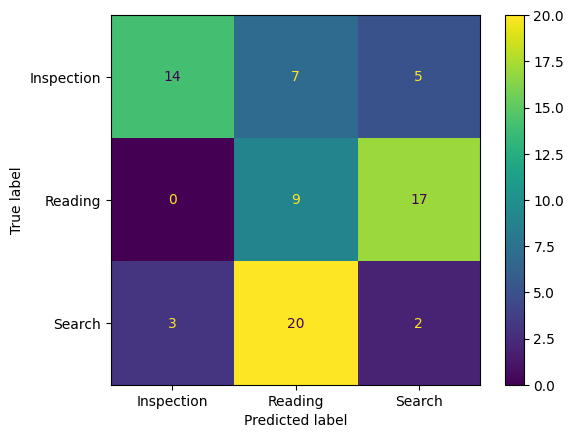

New Feature:


c:\Users\Jannis\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
121,0.401009,0.130435,0.012815,0.905797,0.409091,0.068803
195,0.515043,0.159565,0.021214,0.836120,0.566434,0.079461


New Linear Prediction:


array([[0.00360098, 0.98676579, 0.00963324],
       [0.02035477, 0.96534948, 0.01429575]])

array(['Reading', 'Reading'], dtype=object)

New Poly Prediction:


array([[0.00340819, 0.97360178, 0.02299002],
       [0.00800562, 0.98202886, 0.00996552]])

array(['Reading', 'Reading'], dtype=object)

New RBF Prediction:


array([[0.00460693, 0.97986438, 0.01552869],
       [0.01664662, 0.96837324, 0.01498014]])

array(['Reading', 'Reading'], dtype=object)

New Sig Prediction:


array([[0.39212079, 0.22869778, 0.37918143],
       [0.36337145, 0.45981719, 0.17681136]])

array(['Reading', 'Search'], dtype=object)

In [57]:
%run -i AnSVMClassifierForHL2GazeFeatures.ipynb

## Predict the class for the last arrived data chunk

In [58]:
def normalize_values(df): 
    scaler = MaxAbsScaler()
    training_features_plus_new_row = pd.concat([features, df])  # features -> contains all the features for training and testing
    scaler.fit(training_features_plus_new_row)
    scaled = scaler.transform(training_features_plus_new_row)
    scaled_features = pd.DataFrame(scaled, columns=df.columns)
    row_for_last_chunk = scaled_features.tail(1)
    print("Normalized Features:")
    display(row_for_last_chunk)
    return row_for_last_chunk

In [59]:
row_counter = 0
classes = ["Inspection", "Reading", "Search"]
kernels = [linear, poly, rbf, sig]
def predict_class_for_last_chunk(feature_file_path):
    if os.stat(feature_file_path).st_size != 0:
        df = pd.read_csv(feature_file_path)
        cur_number_of_rows = df.shape[0]
        # only continue if we have a new row
        if cur_number_of_rows > row_counter:
            last_row = df.tail(1)
            display(last_row)
            
            lr_features= last_row[["meanFix", "maxFix", "varFix", "xDir", "yDir", "fixDensPerBB"]]
            last_row = normalize_values(lr_features)
            
            classes = linear.classes_
            # print(f"\n---\nclasses: {classes}")
            
            results = {}
            
            for kernel in kernels:
                new_pred_prob = kernel.predict_proba(last_row)
                new_pred_class = kernel.predict(last_row)
                # print("\n---\nNew Prediction:")
                display(new_pred_prob)
                display(new_pred_class)
                pred_list = new_pred_prob.tolist()[0]
                max_prob = max(pred_list)
                # print(f"max_prob: {max_prob}")
                max_index = pred_list.index(max_prob)
                # print(f"max_index: {max_prob}")
                results[kernel.kernel] = {"pred_class": new_pred_class[0], "max_prob": max_prob, "max_index": max_index }
                # results[kernel.kernel] = [new_pred_class[0], max_prob, max_index ]
                
            display(results)
        
            
            max_proba = {max(float(d['max_prob']) for d in results.values())}
            key = [i for i in results if results[i]['max_prob']==max_proba]
            # print(f"max_proba: {max_proba}, key: {key}")
            predicts = [d['pred_class'] for d in results.values()]
            final_class_from_predict = max(set(predicts), key = predicts.count)
            # print(f"final_class_from_predict: {final_class_from_predict}")
            
            
            new_linear_pred_prob = linear.predict_proba(last_row)
            new_linear_pred_class = linear.predict(last_row)
            # print("\n---\nNew Linear Prediction:")
            # display(new_linear_pred_prob)
            # display(new_linear_pred_class)
            lin_list = new_linear_pred_prob.tolist()[0]
            lin_max_prob = max(lin_list)
            # print(f"lin_max_prob: {lin_max_prob}")
            lin_max_index = lin_list.index(lin_max_prob)
            # print(f"lin_max_index: {lin_max_index}")

            new_poly_pred_prob = poly.predict_proba(last_row)
            new_poly_pred_class = poly.predict(last_row)
            # print("\n---\nNew Poly Prediction:")
            # display(new_poly_pred_prob)
            # display(new_poly_pred_class)
            poly_list = new_poly_pred_prob.tolist()[0]
            poly_max_prob = max(poly_list)
            # print(f"poly_max_prob: {poly_max_prob}")
            poly_max_index = poly_list.index(poly_max_prob)
            # print(f"poly_max_index: {poly_max_index}")

            new_rbf_pred_prob = rbf.predict_proba(last_row)
            new_rbf_pred_class = rbf.predict(last_row)
            # print("\n---\nNew RBF Prediction:")
            # display(new_rbf_pred_prob)
            # display(new_rbf_pred_class)
            rbf_list = new_rbf_pred_prob.tolist()[0]
            rbf_max_prob = max(rbf_list)
            # print(f"rbf_max_prob: {rbf_max_prob}")
            rbf_max_index = rbf_list.index(rbf_max_prob)
            # print(f"rbf_max_index: {rbf_max_index}")
            

            new_sig_pred_prob = sig.predict_proba(last_row)
            new_sig_pred_class = sig.predict(last_row)
            # print("\n---\nNew Sig Prediction:")
            # display(new_sig_pred_prob)
            # display(new_sig_pred_class)
            sig_list = new_sig_pred_prob.tolist()[0]
            sig_max_prob = max(sig_list)
            # print(f"sig_max_prob: {sig_max_prob}")
            sig_max_index = sig_list.index(sig_max_prob)
            # print(f"sig_max_index: {sig_max_index}")
            
            print("----------------")
            max_probs = { lin_max_prob: lin_max_index, poly_max_prob: poly_max_index,
                        rbf_max_prob: rbf_max_index}
            
            max_prediction_value = max(max_probs, key=float)
            # print(max_prediction_value)
            final_max_index = max_probs[max_prediction_value]
            final_class_from_probs = classes[final_max_index]
            
            # print(f"final_class_from_probs: {final_class_from_probs}")
            
            predicts = [new_linear_pred_class[0], new_poly_pred_class[0], new_rbf_pred_class[0]]
            final_class_from_predict = max(set(predicts), key = predicts.count)
            # print(f"final_class_from_predict: {final_class_from_predict}")
            
            
            same_class_predicted = (final_class_from_probs == final_class_from_predict)
            # print(f"same_class_predicted: {same_class_predicted}")
            
            if (same_class_predicted and max_prediction_value > 0.5):
                # send request to HL2 with class and probability
                send_activity(final_class_from_probs, max_prediction_value)
            
# predict_class_for_last_chunk("FeatureFiles/feature_list_P09.csv")

## Send the recognized activity back to the HoloLens 2 

⚠️ Make sure to set the correct IP address for the HL2 in line 10!
If you run the app vie Holographic remoting, this is your PC's IP address.

In [64]:
import urllib.parse
import requests
import random
import time

# Remember to change the IP address and port if needed!
# Start the HL2 app first, an input the url and port that you see in MR here
holo_url = "http://10.2.2.152:52739"

def send_activity(activity, probability):

    url = "{}/?activity={}&probability={}".format(str(holo_url), str(activity), str(probability))
    print(url)

    try:
        r = requests.get(url, timeout=120)
        print(r)
        if r.status_code == 200:
            print("Notified Hololens about activity {}".format(activity))
        else:
            print("Request {} failed with status code {}".format(url, r.status_code))
    except requests.ConnectionError as e:
        print("OOPS!! Connection Error. Make sure you are connected to Internet. Technical Details given below.\n")
        print(str(e))
    except requests.Timeout as e:
        print("OOPS!! Timeout Error")
        print(str(e))
    except requests.RequestException as e:
        print("OOPS!! General Error")
        print(str(e))

    else:
        return

def create_and_send_test_data():
    activities = ["reading", "writing", "searching", "inspecting"]
    a = random.randint(0, 3)
    activity = activities[a]
    confidence = random.uniform(0, 1)
    print(f"{activity}: {confidence}")
    send_activity(activity, confidence)


def sender():
    start_time = time.time()
    interval = 5
    for i in range(20):
        time.sleep(start_time + i * interval - time.time())
        create_and_send_test_data()
        print("sent data")

def send_this_desktop_ip_to_holo(desktop_ip, port):

    # holo_url = "http://10.2.2.172:52434"
    # holo_url = "http://10.2.2.150:53625"
    # holo_url = "http://localhost:5000"
    # holo_url = "http://130.82.26.8:5000"
    
    desktop_ip = urllib.parse.quote(desktop_ip)

    url = "{}/?desktopip={}&port={}".format(str(holo_url), str(desktop_ip), str(port))
    print(url)

    try:
        r = requests.get(url, timeout=60)
        print(r)
        if r.status_code == 200:
            print("Notified Hololens about IP address {}".format(desktop_ip))
        else:
            print("Request {} failed with status code {}".format(url, r.status_code))
    except requests.ConnectionError as e:
        print("OOPS!! Connection Error. Make sure you are connected to Internet. Technical Details given below.\n")
        print(str(e))
    except requests.Timeout as e:
        print("OOPS!! Timeout Error")
        print(str(e))
    except requests.RequestException as e:
        print("OOPS!! General Error")
        print(str(e))

    else:
        return
    
    
# if __name__ == '__main__':
    # sender()


## Send this desktop's IP address to the HL2
This enables the HL2 to send the gaze data correctly to the computer where this script is running.
Make sure to enter your computer's IP-address and a free port.

In [65]:
import socket

def find_free_port():
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(('', 0))  # 0 means to select an arbitrary unused port
        return s.getsockname()[1]

free_port = find_free_port()
print(f"Free port found: {free_port}")

Free port found: 52745


In [66]:
ipaddress = "10.2.2.152"
# ipaddress = "localhost"
# ipaddress = "130.82.27.178"
send_this_desktop_ip_to_holo(ipaddress, free_port)

http://10.2.2.152:52739/?desktopip=10.2.2.152&port=52745
<Response [200]>
Notified Hololens about IP address 10.2.2.152


## Run a simple Flask server that receives the raw gaze data from the HL2
Make sure to enter your computer's IP-address and a suitable port in the last line. \
Note: `0.0.0.0` as IP address lets the server listen on all its IP addresses, usually 127.0.0.1 and the public IP address.

In [67]:
from flask_executor import Executor

import logging
logger = logging.getLogger('waitress')
logger.setLevel(logging.DEBUG)

app = Flask(__name__)
executor = Executor(app)

@app.route('/', methods=['POST', 'PUT'])
def result():
    new_csv = request.files["gazedata"].read()
    filename = request.form["filename"]
    print(f"filename: {filename}")
    filepath = os.path.join("./OnlineGazeDataChunks/", filename)
    print(f"filepath: {filepath}")
    outF = open(filepath, "wb")
    outF.write(new_csv)
    executor.submit(start_feature_calculation,filepath)
    return 'Received !'  

# '''
def start_feature_calculation(filepath):
    print("start fc for: ", filepath)
    if os.stat(filepath).st_size != 0:
        print(f"File {filepath} is not empty, start feature calculation")
        feature_file_path = csv_to_features(filepath)
        if os.stat(feature_file_path).st_size != 0:
            print("start prediction for: ", feature_file_path)
            predict_class_for_last_chunk(feature_file_path)
        else:
            print(f"File {feature_file_path} is empty!")
    else:
        print(f"File {filepath} is empty!")
# '''

if __name__ == '__main__':
    from waitress import serve
    serve(app, listen=f"0.0.0.0:{free_port}")
    # serve(app, listen="10.2.2.152:5555")


INFO:waitress:Serving on http://0.0.0.0:52745


filename: chunk_2025-09-30_10-37-13_000.csv
filepath: ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-13_000.csv
start fc for:  ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-13_000.csv
File ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-13_000.csv is empty!
filename: chunk_2025-09-30_10-37-23_001.csv
filepath: ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-23_001.csv
start fc for:  ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-23_001.csv
File ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-23_001.csv is not empty, start feature calculation
Feature calculation done for: ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-23_001.csv
Feature file path: ./OnlineFeatureFiles/feature_list_P001.csv
start prediction for:  ./OnlineFeatureFiles/feature_list_P001.csv


,meanFix,minFix,maxFix,varFix,stdFix,meanDis,minDis,maxDis,varDis,stdDisp,...,blinkMean,blinkMin,blinkMax,blinkRate,xDir,yDir,fixDensPerBB,label,duration,participant_id
0,183.148148,101,579,14051.669516,118.539738,0.033378,0.027929,0.054694,0.000056,0.007496,...,0,0,0,0,0.423077,0.384615,31.140133,NaN,10,2


Normalized Features:


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
385,0.300802,0.12587,0.011726,0.459866,0.472028,0.020089


array([[0.04855439, 0.00292006, 0.94852554]])

array(['Search'], dtype=object)

array([[0.11174265, 0.02178003, 0.86647732]])

array(['Search'], dtype=object)

array([[0.05301394, 0.00373943, 0.94324664]])

array(['Search'], dtype=object)

array([[0.43665961, 0.06256717, 0.50077321]])

array(['Reading'], dtype=object)

{'linear': {'pred_class': 'Search',
  'max_prob': 0.9485255442223575,
  'max_index': 2},
 'poly': {'pred_class': 'Search',
  'max_prob': 0.8664773245698849,
  'max_index': 2},
 'rbf': {'pred_class': 'Search',
  'max_prob': 0.9432466373550343,
  'max_index': 2},
 'sigmoid': {'pred_class': 'Reading',
  'max_prob': 0.5007732117309077,
  'max_index': 2}}

----------------
http://10.2.2.152:52739/?activity=Search&probability=0.9485255442223575
<Response [200]>
Notified Hololens about activity Search
filename: chunk_2025-09-30_10-37-33_002.csv
filepath: ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-33_002.csv
start fc for:  ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-33_002.csv
File ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-33_002.csv is not empty, start feature calculation
Feature calculation done for: ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-33_002.csv
Feature file path: ./OnlineFeatureFiles/feature_list_P001.csv
start prediction for:  ./OnlineFeatureFiles/feature_list_P001.csv


,meanFix,minFix,maxFix,varFix,stdFix,meanDis,minDis,maxDis,varDis,stdDisp,...,blinkMean,blinkMin,blinkMax,blinkRate,xDir,yDir,fixDensPerBB,label,duration,participant_id
1,229.869565,101,649,33308.573123,182.506365,0.032162,0.012132,0.058566,0.000087,0.009313,...,0,0,0,0,0.681818,0.454545,17.667238,NaN,10,2


Normalized Features:


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
385,0.377537,0.141087,0.027795,0.741107,0.557851,0.011397


array([[0.03793108, 0.66755733, 0.2945116 ]])

array(['Reading'], dtype=object)

array([[0.04303481, 0.49649261, 0.46047258]])

array(['Search'], dtype=object)

array([[0.03498357, 0.64313971, 0.32187672]])

array(['Reading'], dtype=object)

array([[0.38754083, 0.2450826 , 0.36737657]])

array(['Reading'], dtype=object)

{'linear': {'pred_class': 'Reading',
  'max_prob': 0.6675573285654133,
  'max_index': 1},
 'poly': {'pred_class': 'Search',
  'max_prob': 0.49649261058129646,
  'max_index': 1},
 'rbf': {'pred_class': 'Reading',
  'max_prob': 0.6431397126395172,
  'max_index': 1},
 'sigmoid': {'pred_class': 'Reading',
  'max_prob': 0.38754083137266915,
  'max_index': 0}}

----------------
http://10.2.2.152:52739/?activity=Reading&probability=0.6675573285654133
<Response [200]>
Notified Hololens about activity Reading
filename: chunk_2025-09-30_10-37-43_003.csv
filepath: ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-43_003.csv
start fc for:  ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-43_003.csv
File ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-43_003.csv is not empty, start feature calculation
Feature calculation done for: ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-43_003.csv
Feature file path: ./OnlineFeatureFiles/feature_list_P001.csv
start prediction for:  ./OnlineFeatureFiles/feature_list_P001.csv


,meanFix,minFix,maxFix,varFix,stdFix,meanDis,minDis,maxDis,varDis,stdDisp,...,blinkMean,blinkMin,blinkMax,blinkRate,xDir,yDir,fixDensPerBB,label,duration,participant_id
2,282.357143,101,956,50014.312169,223.638798,0.034077,0.028018,0.071177,0.000112,0.010589,...,0,0,0,0,0.481481,0.444444,123.095737,NaN,10,2


Normalized Features:


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
385,0.463742,0.207826,0.041735,0.523349,0.545455,0.07941


array([[0.41894239, 0.0397435 , 0.5413141 ]])

array(['Search'], dtype=object)

array([[0.31548127, 0.07234079, 0.61217794]])

array(['Search'], dtype=object)

array([[0.41510904, 0.03877336, 0.5461176 ]])

array(['Search'], dtype=object)

array([[0.39571346, 0.12620831, 0.47807823]])

array(['Reading'], dtype=object)

{'linear': {'pred_class': 'Search',
  'max_prob': 0.5413141034933152,
  'max_index': 2},
 'poly': {'pred_class': 'Search',
  'max_prob': 0.6121779369272667,
  'max_index': 2},
 'rbf': {'pred_class': 'Search',
  'max_prob': 0.5461175951236704,
  'max_index': 2},
 'sigmoid': {'pred_class': 'Reading',
  'max_prob': 0.47807822668738914,
  'max_index': 2}}

----------------
http://10.2.2.152:52739/?activity=Search&probability=0.6121779369272667
<Response [200]>
Notified Hololens about activity Search
filename: chunk_2025-09-30_10-37-53_004.csv
filepath: ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-53_004.csv
start fc for:  ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-53_004.csv
File ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-53_004.csv is not empty, start feature calculation
Feature calculation done for: ./OnlineGazeDataChunks/chunk_2025-09-30_10-37-53_004.csv
Feature file path: ./OnlineFeatureFiles/feature_list_P001.csv
start prediction for:  ./OnlineFeatureFiles/feature_list_P001.csv


,meanFix,minFix,maxFix,varFix,stdFix,meanDis,minDis,maxDis,varDis,stdDisp,...,blinkMean,blinkMin,blinkMax,blinkRate,xDir,yDir,fixDensPerBB,label,duration,participant_id
3,244.608696,102,924,53747.703557,231.83551,0.035225,0.028078,0.057575,0.000087,0.009347,...,0,0,0,0,0.454545,0.454545,16.391143,NaN,10,2


Normalized Features:


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
385,0.401744,0.20087,0.044851,0.494071,0.557851,0.010574


array([[0.14256487, 0.01548929, 0.84194584]])

array(['Search'], dtype=object)

array([[0.14448586, 0.03992014, 0.815594  ]])

array(['Search'], dtype=object)

array([[0.14194772, 0.0161836 , 0.84186868]])

array(['Search'], dtype=object)

array([[0.41762013, 0.10109841, 0.48128146]])

array(['Reading'], dtype=object)

{'linear': {'pred_class': 'Search',
  'max_prob': 0.8419458402004151,
  'max_index': 2},
 'poly': {'pred_class': 'Search',
  'max_prob': 0.8155939992898767,
  'max_index': 2},
 'rbf': {'pred_class': 'Search',
  'max_prob': 0.8418686793755285,
  'max_index': 2},
 'sigmoid': {'pred_class': 'Reading',
  'max_prob': 0.4812814609059816,
  'max_index': 2}}

----------------
http://10.2.2.152:52739/?activity=Search&probability=0.8419458402004151
<Response [200]>
Notified Hololens about activity Search
filename: chunk_2025-09-30_10-38-03_005.csv
filepath: ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-03_005.csv
start fc for:  ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-03_005.csv
File ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-03_005.csv is not empty, start feature calculation
Feature calculation done for: ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-03_005.csv
Feature file path: ./OnlineFeatureFiles/feature_list_P001.csv
start prediction for:  ./OnlineFeatureFiles/feature_list_P001.csv


,meanFix,minFix,maxFix,varFix,stdFix,meanDis,minDis,maxDis,varDis,stdDisp,...,blinkMean,blinkMin,blinkMax,blinkRate,xDir,yDir,fixDensPerBB,label,duration,participant_id
4,274.181818,101,1023,56854.727273,238.442293,0.038977,0.025869,0.116827,0.000522,0.022848,...,0,0,0,0,0.666667,0.380952,28.572629,NaN,10,2


Normalized Features:


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
385,0.450315,0.222391,0.047443,0.724638,0.467532,0.018432


array([[0.06734856, 0.75924282, 0.17340862]])

array(['Reading'], dtype=object)

array([[0.05828491, 0.63732063, 0.30439446]])

array(['Reading'], dtype=object)

array([[0.06005248, 0.74645311, 0.19349441]])

array(['Reading'], dtype=object)

array([[0.4006473 , 0.17118266, 0.42817004]])

array(['Reading'], dtype=object)

{'linear': {'pred_class': 'Reading',
  'max_prob': 0.7592428228543787,
  'max_index': 1},
 'poly': {'pred_class': 'Reading',
  'max_prob': 0.6373206348822963,
  'max_index': 1},
 'rbf': {'pred_class': 'Reading',
  'max_prob': 0.7464531102924055,
  'max_index': 1},
 'sigmoid': {'pred_class': 'Reading',
  'max_prob': 0.4281700393159514,
  'max_index': 2}}

----------------
http://10.2.2.152:52739/?activity=Reading&probability=0.7592428228543787
<Response [200]>
Notified Hololens about activity Reading
filename: chunk_2025-09-30_10-38-13_006.csv
filepath: ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-13_006.csv
start fc for:  ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-13_006.csv
File ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-13_006.csv is not empty, start feature calculation
Feature calculation done for: ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-13_006.csv
Feature file path: ./OnlineFeatureFiles/feature_list_P001.csv
start prediction for:  ./OnlineFeatureFiles/feature_list_P001.csv


,meanFix,minFix,maxFix,varFix,stdFix,meanDis,minDis,maxDis,varDis,stdDisp,...,blinkMean,blinkMin,blinkMax,blinkRate,xDir,yDir,fixDensPerBB,label,duration,participant_id
5,875.8,136,1739,410207.288889,640.474269,0.036129,0.027904,0.090943,0.000388,0.019688,...,0,0,0,0,0.666667,0.222222,56.046906,NaN,10,2


Normalized Features:


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
385,1.0,0.378043,0.342303,0.724638,0.272727,0.036156


array([[0.13787138, 0.8609993 , 0.00112932]])

array(['Reading'], dtype=object)

array([[0.37122002, 0.53304698, 0.095733  ]])

array(['Inspection'], dtype=object)

array([[0.45155065, 0.51383008, 0.03461927]])

array(['Reading'], dtype=object)

array([[0.34043094, 0.33311516, 0.3264539 ]])

array(['Inspection'], dtype=object)

{'linear': {'pred_class': 'Reading',
  'max_prob': 0.8609992974369683,
  'max_index': 1},
 'poly': {'pred_class': 'Inspection',
  'max_prob': 0.5330469762334665,
  'max_index': 1},
 'rbf': {'pred_class': 'Reading',
  'max_prob': 0.5138300841568291,
  'max_index': 1},
 'sigmoid': {'pred_class': 'Inspection',
  'max_prob': 0.34043094076966735,
  'max_index': 0}}

----------------
http://10.2.2.152:52739/?activity=Reading&probability=0.8609992974369683
<Response [200]>
Notified Hololens about activity Reading
filename: chunk_2025-09-30_10-38-23_007.csv
filepath: ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-23_007.csv
start fc for:  ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-23_007.csv
File ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-23_007.csv is not empty, start feature calculation
Feature calculation done for: ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-23_007.csv
Feature file path: ./OnlineFeatureFiles/feature_list_P001.csv
start prediction for:  ./OnlineFeatureFiles/feature_list_P001.csv


,meanFix,minFix,maxFix,varFix,stdFix,meanDis,minDis,maxDis,varDis,stdDisp,...,blinkMean,blinkMin,blinkMax,blinkRate,xDir,yDir,fixDensPerBB,label,duration,participant_id
6,339.190476,102,1459,129899.061905,360.415124,0.03477,0.027962,0.05909,0.000105,0.010227,...,0,0,0,0,0.35,0.55,19.410283,NaN,10,2


Normalized Features:


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
385,0.557085,0.317174,0.108396,0.380435,0.675,0.012522


array([[0.59776921, 0.00540954, 0.39682125]])

array(['Inspection'], dtype=object)

array([[0.23589807, 0.01041976, 0.75368217]])

array(['Search'], dtype=object)

array([[0.57059789, 0.00729067, 0.42211144]])

array(['Inspection'], dtype=object)

array([[0.35506778, 0.224874  , 0.42005822]])

array(['Inspection'], dtype=object)

{'linear': {'pred_class': 'Inspection',
  'max_prob': 0.5977692088256503,
  'max_index': 0},
 'poly': {'pred_class': 'Search',
  'max_prob': 0.7536821678919594,
  'max_index': 2},
 'rbf': {'pred_class': 'Inspection',
  'max_prob': 0.5705978942913345,
  'max_index': 0},
 'sigmoid': {'pred_class': 'Inspection',
  'max_prob': 0.4200582176689094,
  'max_index': 2}}

----------------
filename: chunk_2025-09-30_10-38-33_008.csv
filepath: ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-33_008.csv
start fc for:  ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-33_008.csv
File ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-33_008.csv is not empty, start feature calculation
Feature calculation done for: ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-33_008.csv
Feature file path: ./OnlineFeatureFiles/feature_list_P001.csv
start prediction for:  ./OnlineFeatureFiles/feature_list_P001.csv


,meanFix,minFix,maxFix,varFix,stdFix,meanDis,minDis,maxDis,varDis,stdDisp,...,blinkMean,blinkMin,blinkMax,blinkRate,xDir,yDir,fixDensPerBB,label,duration,participant_id
7,390.5,102,1569,161703.315789,402.123508,0.029483,0.027942,0.032496,0.000002,0.001331,...,0,0,0,0,0.526316,0.578947,47.629884,NaN,10,2


Normalized Features:


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
385,0.641356,0.341087,0.134936,0.572082,0.710526,0.030726


array([[0.66523352, 0.19145593, 0.14331055]])

array(['Inspection'], dtype=object)

array([[0.4704226, 0.1430438, 0.3865336]])

array(['Inspection'], dtype=object)

array([[0.6485004 , 0.18058142, 0.17091819]])

array(['Inspection'], dtype=object)

array([[0.34877382, 0.49569335, 0.15553283]])

array(['Search'], dtype=object)

{'linear': {'pred_class': 'Inspection',
  'max_prob': 0.6652335213129774,
  'max_index': 0},
 'poly': {'pred_class': 'Inspection',
  'max_prob': 0.4704225951609595,
  'max_index': 0},
 'rbf': {'pred_class': 'Inspection',
  'max_prob': 0.6485003966471939,
  'max_index': 0},
 'sigmoid': {'pred_class': 'Search',
  'max_prob': 0.4956933451403609,
  'max_index': 1}}

----------------
http://10.2.2.152:52739/?activity=Inspection&probability=0.6652335213129774
<Response [200]>
Notified Hololens about activity Inspection
filename: chunk_2025-09-30_10-38-43_009.csv
filepath: ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-43_009.csv
start fc for:  ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-43_009.csv
File ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-43_009.csv is not empty, start feature calculation
Feature calculation done for: ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-43_009.csv
Feature file path: ./OnlineFeatureFiles/feature_list_P001.csv
start prediction for:  ./OnlineFeatureFiles/feature_list_P001.csv


,meanFix,minFix,maxFix,varFix,stdFix,meanDis,minDis,maxDis,varDis,stdDisp,...,blinkMean,blinkMin,blinkMax,blinkRate,xDir,yDir,fixDensPerBB,label,duration,participant_id
8,382.722222,102,1433,140514.447712,374.852568,0.033216,0.027995,0.06373,0.000086,0.009299,...,0,0,0,0,0.470588,0.529412,27.30192,NaN,10,2


Normalized Features:


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
385,0.628581,0.311522,0.117254,0.511509,0.649733,0.017613


array([[0.66547197, 0.08545108, 0.24907694]])

array(['Inspection'], dtype=object)

array([[0.33394797, 0.09733767, 0.56871437]])

array(['Search'], dtype=object)

array([[0.64447659, 0.08437016, 0.27115325]])

array(['Inspection'], dtype=object)

array([[0.34574533, 0.37689435, 0.27736032]])

array(['Inspection'], dtype=object)

{'linear': {'pred_class': 'Inspection',
  'max_prob': 0.6654719739409641,
  'max_index': 0},
 'poly': {'pred_class': 'Search',
  'max_prob': 0.5687143656246152,
  'max_index': 2},
 'rbf': {'pred_class': 'Inspection',
  'max_prob': 0.6444765908757065,
  'max_index': 0},
 'sigmoid': {'pred_class': 'Inspection',
  'max_prob': 0.37689434628217156,
  'max_index': 1}}

----------------
http://10.2.2.152:52739/?activity=Inspection&probability=0.6654719739409641
<Response [200]>
Notified Hololens about activity Inspection
filename: chunk_2025-09-30_10-38-53_010.csv
filepath: ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-53_010.csv
start fc for:  ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-53_010.csv
File ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-53_010.csv is not empty, start feature calculation
Feature calculation done for: ./OnlineGazeDataChunks/chunk_2025-09-30_10-38-53_010.csv
Feature file path: ./OnlineFeatureFiles/feature_list_P001.csv
start prediction for:  ./OnlineFeatureFiles/feature_list_P001.csv


,meanFix,minFix,maxFix,varFix,stdFix,meanDis,minDis,maxDis,varDis,stdDisp,...,blinkMean,blinkMin,blinkMax,blinkRate,xDir,yDir,fixDensPerBB,label,duration,participant_id
9,297.826087,102,921,39594.604743,198.983931,0.031184,0.009581,0.067707,0.000094,0.009696,...,0,0,0,0,0.545455,0.545455,49.573439,NaN,10,2


Normalized Features:


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
385,0.489148,0.200217,0.03304,0.592885,0.669421,0.03198


array([[0.29180166, 0.18218693, 0.52601141]])

array(['Search'], dtype=object)

array([[0.2134143 , 0.21506417, 0.57152153]])

array(['Search'], dtype=object)

array([[0.28850427, 0.18169996, 0.52979577]])

array(['Search'], dtype=object)

array([[0.35820837, 0.36491857, 0.27687306]])

array(['Reading'], dtype=object)

{'linear': {'pred_class': 'Search',
  'max_prob': 0.5260114143482162,
  'max_index': 2},
 'poly': {'pred_class': 'Search',
  'max_prob': 0.5715215346843494,
  'max_index': 2},
 'rbf': {'pred_class': 'Search',
  'max_prob': 0.529795767837999,
  'max_index': 2},
 'sigmoid': {'pred_class': 'Reading',
  'max_prob': 0.36491857420705165,
  'max_index': 1}}

----------------
http://10.2.2.152:52739/?activity=Search&probability=0.5715215346843494
<Response [200]>
Notified Hololens about activity Search
